In [222]:
import numpy as np
import matplotlib.pyplot as plt
from sim import create_solar_system, sim_step

G = 6.67e-11  # Gravitational Constant
dt = 60 * 60 * 24
steps = 365*100


In [223]:
def tot_energy(bodies):
    T = sum(0.5 * body.mass * np.dot(body.velocity, body.velocity) for body in bodies)
    V = 0.0
    for i, b_i in enumerate(bodies):
        for b in bodies[i + 1 :]:
            V -= G * b.mass * b_i.mass / (np.linalg.norm(b_i.position - b.position))
    return T + V

def ang_momentum(bodies):
    L = np.zeros(3)
    for b in bodies:
        L += b.mass * np.cross(b.position, b.velocity)
    return L

In [224]:
def euler_step(bodies, dt):
    forces = [np.zeros(3) for _ in bodies]
    for i, b_i in enumerate(bodies):
        for j, b_j in enumerate(bodies[i+1:], i+1):
            r = b_j.position - b_i.position
            dist = np.linalg.norm(r)
            f = G * b_i.mass * b_j.mass * r / dist**3
            forces[i] += f
            forces[j] -= f
    for i, b in enumerate(bodies):
        b.position += b.velocity * dt
        b.velocity += forces[i] / b.mass * dt

In [225]:
def compute_acc(pos, masses):
    n = len(masses)
    acc = np.zeros((n, 3))
    for i in range(n):
        for j in range(i+1, n):
            r = pos[j] - pos[i]
            dist = np.linalg.norm(r)
            f = G * masses[j]*masses[i] * r / dist**3
            acc[i] += f/masses[i]
            acc[j] -= f/masses[j]
    return acc

def rk4(bodies, dt):
    n = len(bodies)
    masses = [b.mass for b in bodies]

    x0 = [b.position.copy() for b in bodies]
    v0 = [b.velocity.copy() for b in bodies]
    a1 = compute_acc(x0, masses)
    k1_v = a1
    k1_x = v0

    x1 = [x0[i] + 0.5 * dt * k1_x[i] for i in range(n)]
    v1 = [v0[i] +0.5*dt*k1_v[i] for i in range(n)]
    a2 = compute_acc(x1, masses)
    k2_v = a2
    k2_x = v1

    x2 = [x0[i] + 0.5 * dt * k2_x[i] for i in range(n)]
    v2 = [v0[i] +0.5*dt*k2_v[i] for i in range(n)]
    a3 = compute_acc(x2, masses)
    k3_v = a3
    k3_x = v2

    x3 = [x0[i] + dt * k3_x[i] for i in range(n)]
    v3 = [v0[i] + dt * k3_v[i] for i in range(n)]
    a4 = compute_acc(x3, masses)
    k4_v = a4
    k4_x = v3

    for i, body in enumerate(bodies):
        body.position += (dt / 6) * (k1_x[i] + 2 * k2_x[i] + 2 * k3_x[i] + k4_x[i])
        body.velocity += (dt / 6) * (k1_v[i] + 2 * k2_v[i] + 2 * k3_v[i] + k4_v[i])


In [226]:
def run_verlet(include, track, steps, dt):
    system = create_solar_system(include=include, visualize=False)

    system.interact()
    for b in system.bodies:
        b.updateAcc()
        if b.label == track:
            body = b


    x  = np.zeros(steps)
    px = np.zeros(steps)
    E  = np.zeros(steps)
    L  = np.zeros((steps, 3))

    for i in range(steps):
        sim_step(system, dt)
        E[i] = tot_energy(system.bodies)
        L[i] = ang_momentum(system.bodies)
        x[i] = body.position[0]
        px[i] = body.mass * body.velocity[0]

    return {"x": x, "px": px, "E": E, "L": L}


In [227]:
def run_euler(include, track, steps, dt):
    system = create_solar_system(include=include, visualize=False)

    body = next(b for b in system.bodies if b.label == track)

    x  = np.zeros(steps)
    px = np.zeros(steps)
    E  = np.zeros(steps)
    L  = np.zeros((steps, 3))

    for i in range(steps):
        euler_step(system.bodies, dt)
        E[i] = tot_energy(system.bodies)
        L[i] = ang_momentum(system.bodies)
        x[i] = body.position[0]
        px[i] = body.mass * body.velocity[0]

    return {"x": x, "px": px, "E": E, "L": L}


In [228]:
def run_rk4(include, track, steps, dt):
    system = create_solar_system(include=include, visualize=False)

    body = next(b for b in system.bodies if b.label == track)

    x  = np.zeros(steps)
    px = np.zeros(steps)
    E  = np.zeros(steps)
    L  = np.zeros((steps, 3))

    for i in range(steps):
        rk4(system.bodies, dt)
        E[i] = tot_energy(system.bodies)
        L[i] = ang_momentum(system.bodies)
        x[i] = body.position[0]
        px[i] = body.mass * body.velocity[0]

    return {"x": x, "px": px, "E": E, "L": L}


In [229]:
def run_all_methods(include, track, steps, dt):
    return {
        "verlet": run_verlet(include, track, steps, dt),
        "euler": run_euler(include, track, steps, dt),
        "rk4": run_rk4(include, track, steps, dt)
    }

def rel_energy_error(E):
    return (E - E[0]) / abs(E[0])

def ang_momentum_err(L):
    return np.linalg.norm(L - L[0], axis=1) / np.linalg.norm(L[0])

In [230]:
track = "Neptune"
results = run_all_methods(include=["Sun", "Mercury", "Neptune"], track=track, steps=steps, dt=dt)

error_E_verlet = rel_energy_error(results["verlet"]["E"])
error_E_euler = rel_energy_error(results["euler"]["E"])
error_E_rk4 = rel_energy_error(results["rk4"]["E"])
error_L_verlet = ang_momentum_err(results["verlet"]["L"])
error_L_euler = ang_momentum_err(results["euler"]["L"])
error_L_rk4 = ang_momentum_err(results["rk4"]["L"])
x_euler = results["euler"]["x"]
px_euler = results["euler"]["px"]
x_rk4 = results["rk4"]["x"]
px_rk4 = results["rk4"]["px"]
x_verlet = results["verlet"]["x"]
px_verlet = results["verlet"]["px"]

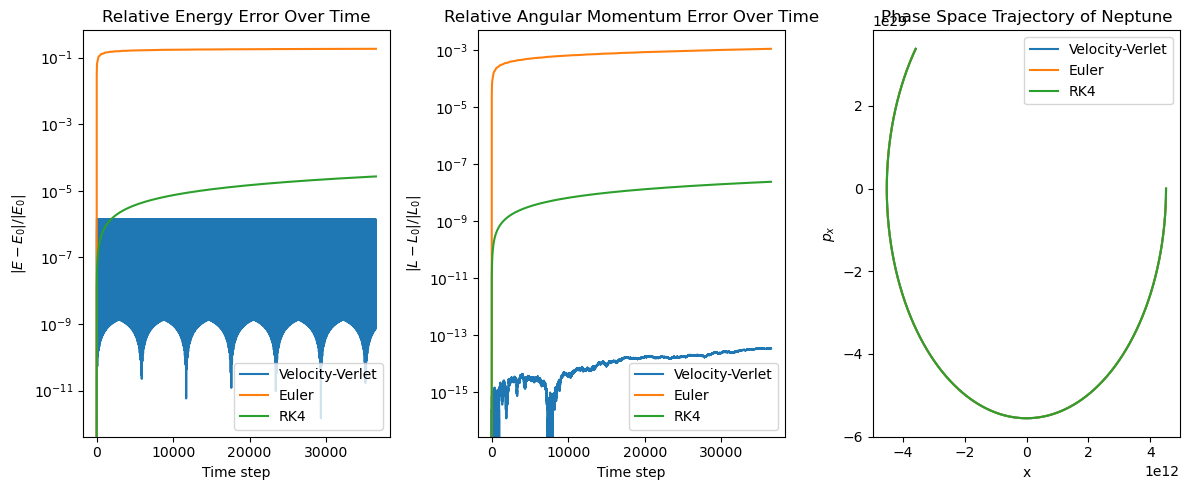

In [231]:
plt.figure(figsize=(12, 5))
# Energy
plt.subplot(1, 3, 1)
plt.semilogy(np.abs(error_E_verlet), label="Velocity-Verlet")
plt.semilogy(np.abs(error_E_euler), label="Euler")
plt.semilogy(np.abs(error_E_rk4), label="RK4")
plt.xlabel("Time step")
plt.ylabel(r"$|E - E_0|/|E_0|$")
plt.title("Relative Energy Error Over Time")
plt.legend()
# Angular momentum
plt.subplot(1, 3, 2)
plt.semilogy(np.abs(error_L_verlet), label="Velocity-Verlet")
plt.semilogy(np.abs(error_L_euler), label="Euler")
plt.semilogy(np.abs(error_L_rk4), label="RK4")
plt.xlabel("Time step")
plt.ylabel(r"$|L - L_0|/|L_0|$")
plt.title("Relative Angular Momentum Error Over Time")
plt.legend()

# Phase Space
plt.subplot(1, 3, 3)
plt.plot(x_verlet, px_verlet, label="Velocity-Verlet")
plt.plot(x_euler, px_euler, label="Euler")
plt.plot(x_rk4, px_rk4, label="RK4")
plt.xlabel("x")
plt.ylabel(r"$p_x$")
plt.title(f"Phase Space Trajectory of {track}")
plt.legend()

plt.tight_layout()
plt.show()